In [1]:
import numpy as np
import torch_geometric as pyg
import pandas as pd
import torch
import os
from torch_geometric.utils import to_undirected

# build full list dictionary
data = torch.load('./data/data.pt')
edge_indices = data.edge_index.numpy()
# create adjacent list
full_list = {}  #edges-index pair
full_list_inverse = {} #index-edges pair
index = 0
for i in range(edge_indices.shape[1]):
    if edge_indices[0][i] <= edge_indices[1][i]:
        full_list[(edge_indices[0][i], edge_indices[1][i])] = index
        full_list_inverse[index] = (edge_indices[0][i], edge_indices[1][i])
        index += 1

/Users/yizhou/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Numerical methods
class my_numerical():
    def __init__(self, mean=0, variance=1):
        self.mean = mean
        self.variance = variance

    # Two functions should work as inverse
    def my_normalize_and_set(self, scores):
        self.mean = np.mean(scores)
        self.variance = np.sum((scores-self.mean) ** 2) / len(scores)
        return (scores - self.mean) / np.sqrt(self.variance)

    def my_normalize_inverse(self, scores):
        return scores * np.sqrt(self.variance) + self.mean
    
    def reset(self):
        self.mean = 0
        self.variance = 1
    

In [3]:
# data proceeding

def read_scores(file_path, numerical):
    scores = []
    try:
        with open(file_path, 'r') as file:
            for line in file:
                score = float(line.strip())
                scores.append(score)
        return numerical.my_normalize_and_set(scores)
    except FileNotFoundError:
        print("File not found.")
        return None
    except ValueError:
        print("Error: Invalid score format in file.")
        return None

def get_edges(csv_path):
    df = pd.read_csv(csv_path)
    edge_arr = df.to_numpy()[:, 1:]
    edges = []
    edge_list = []
    for j in range(edge_arr.shape[0]):
        edge_list.append(edge_arr[j][edge_arr[j] != -1].reshape(2, -1))
    for k in range(6):
        edge_indices = edge_list[k]
        data_list = [0 for l in range(len(full_list))]
        for l in range(edge_indices.shape[1]):
            if edge_indices[0][l] <= edge_indices[1][l]:
                data_list[full_list[(edge_indices[0][l], edge_indices[1][l])]] = 1
        edges.append(data_list)
    return edges

def get_raw_data(dataset, num_submit, numerical):
    score_file = os.path.join(dataset, 'scores.txt')
    scores = read_scores(score_file, numerical)
    X = []
    Y = []
    for i in range(num_submit):
        edges = get_edges(os.path.join(dataset, 'submission-{}.csv'.format(i+1))) # starts from submission-1
        score = [scores[i] for j in range(6)]
        X += edges
        Y += score
    return np.array(X), np.array(Y)

# NOTE: This is a PERFECT csv writing function now. Please DO NOT CHANGE IT.
def construct_edge_list(bitmap):
    edge_list = []
    for i in range(len(bitmap)):
        nodes1 = []
        nodes2 = []
        for j in range(len(bitmap[i])):
            if bitmap[i][j]==1:
                nodes1 += [full_list_inverse[j][0]]
                nodes2 += [full_list_inverse[j][1]]
        edges = nodes1 + nodes2 + nodes2 + nodes1
        edge_list.append(np.array(edges,dtype='int64'))
    return edge_list

def edge_to_csv(edge_list, file):
   # NOTE: Don't change this, used for generating the submission csv
    df = pd.DataFrame(edge_list).fillna(-1).astype(int)
    # fill those empty units with -1 (don't change it)
    df.insert(0, 'ID', list(range(len(edge_list))))
    df.to_csv(file, index=False)

In [4]:
# read data
dataset = './results'
num_submit = 33 #The number should increase everyday!

# Set numerical method
numerical = my_numerical()

X, Y = get_raw_data(dataset, num_submit, numerical)

print(X.shape)
print(Y.shape)
print("mean: ", numerical.mean)
print("variance: ", numerical.variance)

(198, 5069)
(198,)
mean:  0.7936078787878788
variance:  3.581283379246974e-06


In [5]:
# Some models for training and prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def RandomForrest(X_train, y_train, X_test):
    # Use Random Forres tRegressor
    # Initialize the RandomForestRegressor model
    model = RandomForestRegressor(n_estimators=5000, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    return model, y_pred, y_pred_train

def XGBoost(X_train, y_train, X_test):
    model = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    return model, y_pred, y_pred_train


def LightGBM(X_train, y_train, X_test):
    # Convert dataset to LightGBM format
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=[0 for i in range(len(X_test))])

    # Set parameters for LightGBM
    params = {
        'objective': 'regression',
        'metric': 'mse',  # Mean Squared Error
        'verbosity': -1,  # Suppress LightGBM output
        'random_state': 42
    }
    # Train the model
    model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[test_data])

    # Predict on the testing set
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
    return model, y_pred, y_pred_train

# Gaussian Progress Regresson
def Gaussian(X_train, y_train, X_test):
    # Define the kernel for Gaussian Process Regression
    kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))

    # Initialize Gaussian Process Regression model
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

    # Train the model
    gp.fit(X_train, y_train)

    # Predict on the testing set
    y_pred, sigma = gp.predict(X_test, return_std=True)
    y_pred_train, _ = gp.predict(X_train, return_std=True)
    return gp, y_pred, y_pred_train



In [7]:
# Leaning, Currently use RandomForest Regressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

methods = [RandomForrest, XGBoost, LightGBM, Gaussian]
methods_str = ['RandomForrest', 'XGBoost', 'LightGBM', 'Gaussian']
train_mses = []
test_mses = []
for method in methods:
    model, y_pred, y_pred_train = method(X_train, y_train, X_test)
    train_mse = mean_squared_error(numerical.my_normalize_inverse(y_pred_train), numerical.my_normalize_inverse(y_train))
    test_mse = mean_squared_error(numerical.my_normalize_inverse(y_test), numerical.my_normalize_inverse(y_pred))
    train_mses.append(train_mse)
    test_mses.append(test_mse)


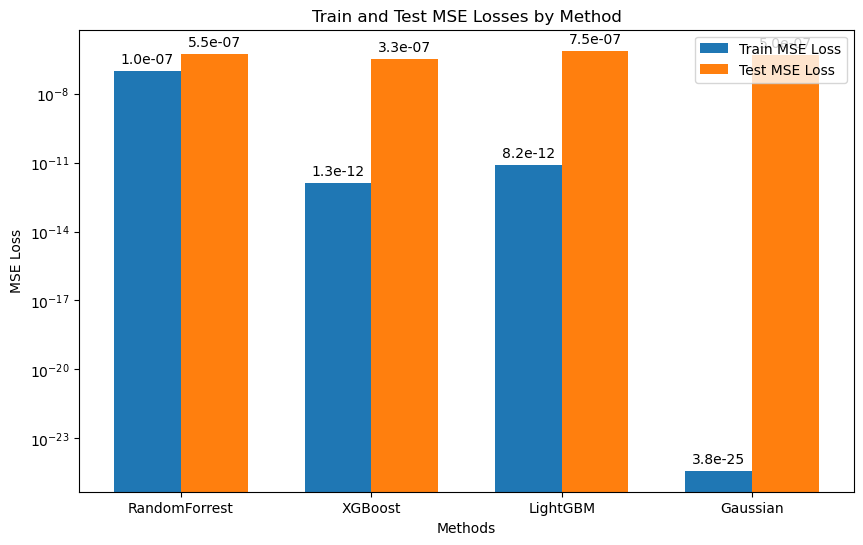

In [11]:
# make graph
import matplotlib.pyplot as plt
import numpy as np

# Define the methods and their corresponding losses


# Number of methods
n_methods = len(methods_str)

# Create an array for the x-axis positions
x = np.arange(n_methods)

# Width of the bars
width = 0.35

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the training and testing losses
bars1 = ax.bar(x - width/2, train_mses, width, label='Train MSE Loss')
bars2 = ax.bar(x + width/2, test_mses, width, label='Test MSE Loss')

# Set logarithmic scale for y-axis
ax.set_yscale('log')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Methods')
ax.set_ylabel('MSE Loss')
ax.set_title('Train and Test MSE Losses by Method')
ax.set_xticks(x)
ax.set_xticklabels(methods_str)
ax.legend()

# Function to add a label above each bar in bars1 and bars2
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1e}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels
add_labels(bars1)
add_labels(bars2)

# Display the plot
plt.savefig('Loss.png')

In [52]:
# test
num_of_tests = 6
mean_accs = []
for i in range(num_of_tests):
    test_file = 't{}.csv'.format(i+1)
    edges = get_edges(test_file)
    pred = numerical.my_normalize_inverse(model.predict(edges))
    mean_accs.append(np.mean(pred))
print("Predicted Mean Accuracy: ", mean_accs)


Predicted Mean Accuracy:  [0.7936531024325092, 0.7931987728769108, 0.7933300689706129, 0.793816347910855, 0.7933946016109678, 0.7981160989984852]


In [39]:
# Count edges
# read data
dataset = './results'
num_submit = 33 #The number should increase everyday!

# Set numerical method
numerical = my_numerical()

X, Y = get_raw_data(dataset, num_submit, numerical)
ones = np.ones(X.shape)
# to count score for each edge
edge_score = np.sum((ones - X) * Y[:, np.newaxis] * np.abs(Y[:, np.newaxis]), axis=0)
edges = np.sum(ones - X, axis=0)
sorted_score = sorted(enumerate(edge_score), key=lambda x: -x[1])


In [40]:
# A rediculious try, by simply deleting the edges with highest score
bitmap = []
for i in range(6):
    ref = [j[0] for j in sorted_score[:(i+1)*100]]
    bits = [int(not k in ref) for k in range(len(full_list))]
    bitmap.append(bits)

print(np.sum(bitmap, axis=1))
edge_list = construct_edge_list(bitmap)
print(len(edge_list), len(edge_list[0]))
edge_to_csv(edge_list, 'submission.csv')
           

[4969 4869 4769 4669 4569 4469]
6 19876


In [28]:
# Second rediculious try, by simply deleting the edges with highest score, incorporating our model
bitmap = []
for i in range(6):
    maxscore = 0
    ref = []
    for t in range(20): #try 5 times
        ref_temp = np.random.choice([j[0] for j in sorted_score[:(i+1)*105]], size = (i+1)*100, replace = False)
        bits_temp = [int(not k in ref_temp) for k in range(len(full_list))]
        score = model.predict([bits_temp], num_iteration=model.best_iteration)
        if score[0] > maxscore:
            ref = ref_temp
            maxscore = score[0]
    print(maxscore)
    bits = [int(not k in ref) for k in range(len(full_list))]
    bitmap.append(bits)

print(np.sum(bitmap, axis=1))
edge_list = construct_edge_list(bitmap)
print(len(edge_list), len(edge_list[0]))
edge_to_csv(edge_list, 'submission.csv')

1.2092315337269097
1.780649037594955
1.6738981663143615
1.7561543042892835
1.7853059982278854
1.6799053562296415
[4969 4869 4769 4669 4569 4469]
6 19876


In [7]:
# test for writing csv
csv1 = 'test.csv'
csv2 = './results/submission-4.csv'
edges1, edges2 = get_edges(csv1), get_edges(csv2)
print(edges1==edges2)

True
